In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from pathlib import Path
import torch
import os
from torchvision import transforms
from torchvision.transforms import ToTensor, Resize, Compose, RandomHorizontalFlip, RandomRotation
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import numpy as np
import cv2
from matplotlib import cm
from scipy.stats import ttest_ind

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/AC297R/images_new/scores-scaled-combined.csv')
df_lmm = df.copy()

In [ ]:
sorted_ids = []
for i in [1,2,3,4,5]:
  s = df_lmm[df_lmm['Id'] == i].sort_values('Timestamp (From Photo)(MMDD-YYYY-HHMMSS)')
  # s['Intervention\n(Boolean)'] = s['Intervention\n(Boolean)'].shift(periods=3, fill_value="FALSE")
  sorted_ids.append(s)
df_tsorted = pd.concat(sorted_ids, ignore_index=True)

In [ ]:
df_tsorted.loc[:, 'Intervention\n(Boolean)'] = df_tsorted['Intervention\n(Boolean)'].apply(lambda s: s.upper().strip())
intervention = df_tsorted['Intervention\n(Boolean)']
x = intervention == 'TRUE'
y = intervention == 'FALSE'

score_cols = ['scores_xuliang', 'scores_siqiao', 'scores_joslyn', 'scores_shuheng', 'scores_siqi']

with_inter = {
    idx: df_tsorted[(df_tsorted['Id'] == idx) & x][score_cols].values
    for idx in [1, 2, 3, 4, 5]
}

without_inter = {
    idx: df_tsorted[(df_tsorted['Id'] == idx) & y][score_cols].values
    for idx in [1, 2, 3, 4, 5]
}

for idx in [1, 2, 3, 4, 5]:
    print(
        f'Image of {score_cols[idx - 1].split("_")[1].capitalize()}',
        '(Rated by all)\n',
        ttest_ind(with_inter[idx].flatten(), without_inter[idx].flatten(), equal_var=False)
    )

Image of Xuliang (Rated by all)
 Ttest_indResult(statistic=3.298985641807417, pvalue=0.0011225793119242517)
Image of Siqiao (Rated by all)
 Ttest_indResult(statistic=-5.632573666697016, pvalue=5.046371910832267e-08)
Image of Joslyn (Rated by all)
 Ttest_indResult(statistic=-1.186655938998483, pvalue=0.23652766136756587)
Image of Shuheng (Rated by all)
 Ttest_indResult(statistic=0.8020202512629168, pvalue=0.4233256522661414)
Image of Siqi (Rated by all)
 Ttest_indResult(statistic=-1.1950391503807787, pvalue=0.23326997111808295)


In [ ]:
def increase_brightness(img, value=30):
    value = np.random.randint(low=0, high=30, size=1)[0]
    img = np.array(img)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

    return Image.fromarray(img.astype('uint8'), 'RGB')

In [ ]:
IMAGE_DIR = Path('/content/drive/Shareddrives/AC297R/images_new')

test_trans = Compose([
    transforms.Lambda(increase_brightness),
    Resize((224, 224)),
    RandomHorizontalFlip(1.0),
    RandomRotation([5, 10]),
    ToTensor(),
])

train_trans = Compose([
    transforms.Lambda(increase_brightness),
    Resize((224, 224)),
    RandomHorizontalFlip(0.5),
    RandomRotation([5, 10]),
    ToTensor(),
])

inf_trans = Compose([
    Resize((224, 224)),
    ToTensor(),
])

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df, inf = False, only_train_trans = True, test_id = 2, test_trans = test_trans, train_trans = train_trans, inf_trans = inf_trans):
        self.xs = []
        self.ys = []
        self.test_id = test_id
        self.test_trans = test_trans
        self.train_trans = train_trans
        self.inf_trans = inf_trans
        self.inf = inf

        for i, row in tqdm(df.iterrows()):
            fn = row['Image Id(Id-Timestamp)']
            im = Image.open(IMAGE_DIR / fn[0] / fn)
            if self.inf == True:
              self.xs.append(inf_trans(im))
              self.ys.append(-1)
              continue
            if only_train_trans == True:
              self.xs.append(train_trans(im))
            elif row.Id == self.test_id:
              self.xs.append(test_trans(im))
            else:
              self.xs.append(train_trans(im))

            self.ys.append(
                float(np.sum([
                    row.scores_xuliang_post_median,
                    row.scores_siqiao_post_median,
                    row.scores_joslyn_post_median,
                    row.scores_shuheng_post_median,
                    row.scores_siqi_post_median
                ]) > 2.0)
              )
    
    def __getitem__(self, i):

        return self.xs[i], self.ys[i]

    def __len__(self):
        return len(self.xs)

In [ ]:
# Process each median
score_cols = ['scores_xuliang', 'scores_siqiao', 'scores_joslyn', 'scores_shuheng', 'scores_siqi']

for col in score_cols:
  df_tsorted[col+'_post_median'] = df_tsorted[['Id', col]].groupby(['Id']).apply(lambda x: x[col] >= x[col].median()).reset_index(drop=True).astype(float)

df_tsorted

,Timestamp (From Photo)(MMDD-YYYY-HHMMSS),Id,Image Id(Id-Timestamp),Temperature (°F),"Activity Level (Categorical), i.e none, light, intense",Applied Lotion/Makeup\n(Boolean),Intervention\n(Boolean),Unnamed: 7,scores_siqiao,scores_siqi,scores_shuheng,scores_xuliang,scores_joslyn,scores_xuliang_post_median,scores_siqiao_post_median,scores_joslyn_post_median,scores_shuheng_post_median,scores_siqi_post_median
0,1015-2022-134230,1,1-1015-2022-134230.jpg,78,None,False,FALSE,NaN,0.571429,0.60,0.500000,0.142857,0.500,0.0,1.0,1.0,1.0,1.0
1,1015-2022-174630,1,1-1015-2022-174630.jpg,78,None,False,FALSE,NaN,0.857143,1.00,0.666667,0.571429,0.500,1.0,1.0,1.0,1.0,1.0
2,1015-2022-232914,1,1-1015-2022-232914.jpg,78,None,False,FALSE,NaN,0.571429,0.40,0.166667,0.428571,0.250,0.0,1.0,0.0,0.0,0.0
3,1016-2022-122933,1,1-1016-2022-122933.jpg,77,None,False,FALSE,NaN,0.571429,0.80,0.333333,0.714286,0.375,1.0,1.0,1.0,1.0,1.0
4,1016-2022-180003,1,1-1016-2022-180003.jpg,77,None,False,FALSE,NaN,0.428571,0.00,0.000000,0.285714,0.250,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,1029-2022-161935,5,5-1029-2022-161935.jpg,75,Light,False,TRUE,NaN,0.500000,0.75,0.500000,0.076923,0.400,0.0,1.0,1.0,1.0,1.0
251,1030-2022-012914,5,5-1030-2022-012914.jpg,75,None,True,TRUE,NaN,0.833333,1.00,0.500000,0.692308,0.800,1.0,1.0,1.0,1.0,1.0
252,1030-2022-172704,5,5-1030-2022-172704.jpg,75,None,True,TRUE,NaN,0.500000,1.00,0.750000,0.846154,0.600,1.0,1.0,1.0,1.0,1.0
253,1030-2022-204923,5,5-1030-2022-204923.jpg,75,None,False,TRUE,NaN,0.333333,0.25,0.500000,0.076923,0.800,0.0,0.0,1.0,1.0,0.0


In [ ]:
all_ids = [1,2,3,4,5]
train_val_ids = [1,2,3,4,5]#[1,3,4,5]
inf_ids = [2]#[id for id in all_ids if id not in train_val_ids]

train_val_df = pd.concat([df_tsorted[df_tsorted['Id'] == i] for i in train_val_ids], ignore_index=True)
inf_df = pd.concat([df_tsorted[df_tsorted['Id'] == i] for i in inf_ids], ignore_index=True)

In [ ]:
BATCH_SIZE = 32

train_val_dataset = ImageDataset(train_val_df, only_train_trans = False, test_trans=test_trans, train_trans=train_trans)
train_indices = np.random.choice(len(train_val_dataset), int(len(train_val_dataset) * 0.8), replace=False)
valid_indices = [i for i in range(len(train_val_dataset)) if i not in train_indices]


train_dateset = torch.utils.data.Subset(train_val_dataset, train_indices)
val_dataset = torch.utils.data.Subset(train_val_dataset, valid_indices)
inf_dataset = ImageDataset(inf_df, inf=True, inf_trans = inf_trans)


train_loader = DataLoader(train_dateset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
inf_loader = DataLoader(inf_dataset, batch_size=BATCH_SIZE, shuffle=False)

255it [02:29,  1.71it/s]
48it [00:09,  4.97it/s]


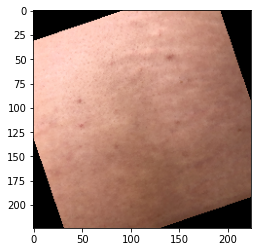

In [ ]:
t = next(iter(train_loader))[0]
import matplotlib.pyplot as plt
plt.imshow(t[0].permute(1, 2, 0))

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
class Net(torch.nn.Module):
    def __init__(self, pretrained_net, last_shape=1000):
        super().__init__()
        self.pretrained_net = pretrained_net
        # for p in self.pretrained_net.parameters():
        #     p.requires_grad = False
        
        for p in list(self.pretrained_net.parameters()):#[-6:]:
            p.requires_grad = True

        self.relu = torch.nn.ReLU()
        self.fc = torch.nn.Linear(last_shape, 1)

    def forward(self, x):
        return self.fc(self.relu(self.pretrained_net(x)))


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(resnet50(weights=ResNet50_Weights.IMAGENET1K_V2), 1000)
model.to(DEVICE)

for name, p in model.named_parameters():
    if p.requires_grad:
        print(name, p.shape)


pretrained_net.conv1.weight torch.Size([64, 3, 7, 7])
pretrained_net.bn1.weight torch.Size([64])
pretrained_net.bn1.bias torch.Size([64])
pretrained_net.layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
pretrained_net.layer1.0.bn1.weight torch.Size([64])
pretrained_net.layer1.0.bn1.bias torch.Size([64])
pretrained_net.layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
pretrained_net.layer1.0.bn2.weight torch.Size([64])
pretrained_net.layer1.0.bn2.bias torch.Size([64])
pretrained_net.layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
pretrained_net.layer1.0.bn3.weight torch.Size([256])
pretrained_net.layer1.0.bn3.bias torch.Size([256])
pretrained_net.layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
pretrained_net.layer1.0.downsample.1.weight torch.Size([256])
pretrained_net.layer1.0.downsample.1.bias torch.Size([256])
pretrained_net.layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
pretrained_net.layer1.1.bn1.weight torch.Size([64])
pretrained_net.layer1.1.bn1.bias torch.Size([64])


In [ ]:
from torch.nn import MSELoss


def compute_mse_loss(model):
  count = 0
  loss = 0
  loss_fn = MSELoss()
  with torch.no_grad():
    for x, y in val_loader:
      y_pred = model(x.to(DEVICE))
      loss += loss_fn(y, y_pred)
      count += len(y)

  return loss / count

In [ ]:
from torch.nn import BCEWithLogitsLoss

def compute_bce_acc(model):
  count = 0
  acc = 0
  loss_fn = BCEWithLogitsLoss()
  with torch.no_grad():
    for x, y in val_loader:
      y = y.type(torch.FloatTensor).to(DEVICE)
      y_pred = model(x.to(DEVICE))
      y_pred = torch.sigmoid(y_pred)
      y_pred = (y_pred > 0.5).cpu().numpy().astype(int)
      y_true = y.cpu().numpy().astype(int)
      acc += (y_true.flatten() == y_pred.flatten()).sum()
      count += len(y)

  return acc / count

In [ ]:
from torch.optim import Adam
from torch.nn import MSELoss
from torch.nn import BCEWithLogitsLoss


optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
loss_fn = BCEWithLogitsLoss()

In [ ]:
for epoch in range(15):
    print(epoch)
    epoch_loss = 0
    for x, y in train_loader:
        y = y.type(torch.FloatTensor)
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y.reshape(-1, 1))
        epoch_loss += loss.item() * len(y)
        loss.backward()
        optimizer.step()

    print('valid acc =', compute_bce_acc(model))
    print('epoch loss =', epoch_loss / len(train_dateset))

0
valid acc = 0.5490196078431373
epoch loss = 0.11871259108039678
1
valid acc = 0.5294117647058824
epoch loss = 0.06339725757054254
2
valid acc = 0.6274509803921569
epoch loss = 0.0747263662370981
3
valid acc = 0.5686274509803921
epoch loss = 0.07204185243622929
4
valid acc = 0.6274509803921569
epoch loss = 0.2392702637349858


## Performing experiments on trained Model

- Permute treatment/no treatment on subject 2 for 1000 times
- Count # of significant p values out of 1000 inferences

In [ ]:
# inf_scores = []
from scipy.stats import ttest_ind

score_col = 'scores_resnet50'
num_exp = 1000
p_values = []
for _ in tqdm(range(num_exp)):
  inf_scores = []
  inter_seq = inf_df["Intervention\n(Boolean)"].apply(lambda x: 1 if x == "TRUE" else 0)
  ran_seq = np.random.permutation(inter_seq.values)
  for x, _ in inf_loader:
      x = x.to(DEVICE)
      inf_scores += list(model(x).detach().cpu().numpy().flatten())
  no_inter_idx = [i for i, v in enumerate(ran_seq) if v == 0]
  inter_idx = [i for i, v in enumerate(ran_seq) if v == 1]
  no_inter_scores = [inf_scores[i] for i in no_inter_idx]
  inter_scores = [inf_scores[i] for i in inter_idx]
  p = ttest_ind(inter_scores, no_inter_scores, equal_var=False)
  p_values.append(p)

# inf_df[score_col] = inf_scores

100%|██████████| 1000/1000 [02:43<00:00,  6.11it/s]


In [ ]:
num_sig = len([p for p in p_values if p.pvalue <= 0.05])
assert num_sig < 50, f"Number of significant values {num_sig} greater than %5"

In [ ]:
len([p for p in p_values if p.pvalue <= 0.05 and p.statistic < 0])

22

In [ ]:
score_col = 'scores_resnet50'
inf_scores = []
for x, _ in inf_loader:
  x = x.to(DEVICE)
  inf_scores += list(torch.sigmoid(model(x)).detach().cpu().numpy().flatten())

inf_df[score_col] = inf_scores

inf_df.loc[:, 'Intervention\n(Boolean)'] = inf_df['Intervention\n(Boolean)'].apply(lambda s: s.upper().strip())
intervention = inf_df['Intervention\n(Boolean)']
x = intervention == 'TRUE'
y = intervention == 'FALSE'


with_inter = {
    idx: inf_df[(inf_df['Id'] == idx) & x][score_col].values
    for idx in inf_ids
}

without_inter = {
    idx: inf_df[(inf_df['Id'] == idx) & y][score_col].values
    for idx in inf_ids
}

In [ ]:
from scipy.stats import ttest_ind
for idx in inf_ids:
    print(
        ttest_ind(with_inter[idx].flatten(), without_inter[idx].flatten(), equal_var=False)
    )

Ttest_indResult(statistic=-3.40650345857815, pvalue=0.0015048579180875965)


In [ ]:
inf_df.to_csv("/content/drive/Shareddrives/AC297R/images_new/siqiao_cnn_inf.csv")